# **시계열 데이터 이상한데?**

오늘은 시계열 데이터에서 이상한 부분을 찾아내는 이상치 탐색(Anomaly Detection)에 대해 배워본다.

    만약 여러분이 수백대의 생산설비가 24시간 무중단 운영중인 대규모의 제조시설  
    운영을 맡고있는 책임자라고 생각해 봅시다.

    그 수백대의 설비는 서로 긴밀하게 맞물려 운영되는데, 자칫 그 중 한 설비에 
    이상이 생기기라도하면 공장 전체가 올스톱되어 어마어마한 손실이 발생하게 될 
    것입니다. 

    문제는, 설비가 고장이나기 직전까지 겉으로 봐서는 아무런 문제가 드러나지 
    않기 때문에 도저히 문제 발생을 미리 예측할 수 없다는 점입니다.

    할수 있는 거라곤 멀쩡하게 잘 쓰고 있는 설비도 '그나마 안심하고 쓸수 있는' 
    안심내구연한이 지나면 무조건 새것으로 교체하거나, 

    아니면 설비 센서 앞에 관리자를 24시간 교대근무시키면서 만일의 사태에 빠르게 
    대응하도록 하는 것뿐이겠지요.


이럴때 정확한 Anomaly Detection 모델을 확보할 수 있다면 큰 도움이 될 것이다.
설비에 부착된 센서의 시계열 데이터를 면밀히 분석해, 이상발생 얼마 전에 나타나는 이상 징후를 빠르게 포착해서 미리 대리할 수 있게 하면, 만일에 발생할수 있는 천문학적 손실을 예방할 수 있는 요긴한 솔루션이 될거다.

곡 시계열이 아니더라도 이미지에 대한 Anomaly Detection 분석을 통해 불량품을 찾아내거나 공항/ 항만에서 반입 금지 품목을 수색하는 등 다양한 용도의 Anomaly Dectection 기법을 생각할 수 있다.

오늘은 우리에게 주어진 데이터를 분석해서 보다 신뢰할 수 있는 데이터로 가공해 가는 전처리 과정의 일부로 접근해 볼까 한다.

"Garbage in,  Garbage out" 이라는 말이 있다.
분석 데이터가 얼마나 중요한지 알려주는 격언이다.

'이상한 데이터 = 이상치(Anomalies)' 는 어떻게 정의할 수 있을까?
"Garbage"소리를 안 들으려면 이상치들은 어떻게 처리해야 할까? 

이번 노드에서는 시계열 데이터 속에서 이상치의 의미를 파악하고, 똑똑하게 찾아내는 방법을 알아보고 이상처리하는 방법까지 연결해 볼 거다.


**학습 목표**

- 시계열 데이터의 이상치의 개념을 이해한다.
- 다양한 방법으로 이상치를 탐색해본다.
- 발견한 이상치를 처리하는 방법을 알아본다.

**목차**
1. 들어가며
2. 이상한 데이터는 어떻게 생겨났을까요?
3. 신입 데이터 분석가 되어보기: 시계열 데이터 준비
4. Outlier/ Novelties 구분하기
5. 확률분포로 이상치 찾아내기
6. 클러스터링으로 이상치 찾아내기
7. LSTM auto encoder로 이상치 찾아내기




#**2. 이상한 데이터는 어떻게 생겨났을까?**

데이터 속에는 유독 혼자서 톡톡 튀는 값들이 있다.

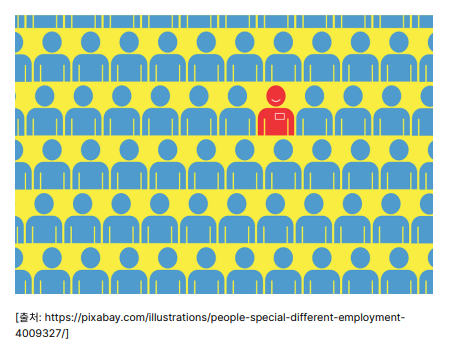

우리는 이 데이터에서 두 가지 방법으로 해석할 수 있다.

1. "세상에는 파란 사람 말고 빨간 사람도 있구나!"
2. "어쩌다가 데이터에 빨간 사람이 들어왔지?"

모델은 데이터를 통해서 외부환경을 학습해요.
모든 사람의 색이 파란색인 데이터만 입력받은 모델은 빨간 사람이나 초록 사람은 예측 할수 없다.

이때, 입력데이터에 나타난 빨간 사람은 모델이 학습할 외부환경을 추가해서 더 좋은 모델이 되게끔 해준다.

그런데 만약 빨간 사람은 존재하지 않고 단순한 데이터 오류라면, 모델은 빨간 사람 데이터를 학습하지 않는편이 더 좋을것이다.

한번이라도 빨간 사람을 학습하면, 특정 경우에는 사람의 색이 빨간색이라고 예측할 수 있고, 그건 늘 틀린답 일테니까.

우리는 이상한 데이터를 보고 판단해야 한다.
"이 데이터는 어떻게 생성된 건가?"



**데이터를 무조건적으로 믿으면 안 되는 이유**

데이터를 100% 믿는 건 굉장히 위험한 행동이다.

우리가 다루는 모든 데이터는 생성/ 측정되고, 수집/ 전달돼서 우리의 컴퓨터로 들어왔다.

이런 데이터 파이프라인 속에서 데이터가 오염될 가능성은 결코 0%가 아니다.

각 단계별 어떤 위험이 있는지 알아보자.

**생성/ 측정 단계**

- 관측자의 실수(휴먼에러)
- 측정 장비의 오류

기상 데이터의 경우, 자동화 측정 장비가 도입되기 전에는 관측관이 직접 수은온도계를 보고, 하늘 상태를 눈으로 봐서 기록했다.

온도계가 고장 났거나, 노후화 됐거나, 관측관의 실수가 있었다면 이상한 데이터가 입력된다.

자동화된 IoT 센서도 문제가 없는 건 아니다. 센서는 종종 오작동을 하거나 고장 나기도 한다.

각종 산업현장에서는 주기적으로 센서 정확도를 점검하나, 그 사이에 발생하면 끔찍한 사고로 연결 되기도 한다.

- 보잉 "추락사고 센서 오작동 때문"

**수집/ 전달 단계**

- 데이터 수집 프로그램의 오류(버그)
- 데이터 관리자의 실수(휴먼에러)
- 데이터 전달 프로그램의 오류(Open API)

급증한 데이터 생성량에 맞춰, 많은 데이터들이 자동 프로그램으로 수집되고 있다.

생성/측정은 정상적으로 이뤄 졌더라도, 수집 프로그램에 버그가 있다면 이상한 데이터가 저장되었을 거다.

**실무에서 가장 흔한 데이터 오염은 데이터 관리자에 의해 발생한다.**

직접 raw 데이터부터 DB까지 뜯어보며 해결할 수 있는 문제가 아니라면 해결하기 가장 까다로운 문제이다.

모든 위험을 벗어나도 Open API 설계에 오류가 있다면, 우리가 수집한 데이터에는 이상한 값이 들어있을 거다.(Open API는 null값을 0으로 반환하는 버그가 가장 흔하다.)

**이상한 데이터를 찾아내는 방법(Anomaly Detection)**

데이터 파이프라인 관리자들은 이런 오류를 막기 위해서 온갖 노력을 기울이고 있다.

그러니 우리는 이런 전제를 세울 수 있다.

"대부분의 데이터는 참이고, 이상한 데이터는 극히 일부일 것이다."

우리는 어떻게 해야 이상한 데이터를 찾아낼 수 있을까?

- 다시 측정한다.
- 같은 데이터의 다른 출처를 찾아서 비교한다(Supervised)
- 데이터 스스로의 특징을 활용해서 찾아낸다 (Unsupervised)

시계열 데이터의 특성상, 과거로 돌아가 다시 측정하는 방법은 불가능하다.

같은 데이터를 제동하는 다른 출처가 있다면 Supervised 방법을 쓸수 있다.

1. 각 데이터를 비교해서 다른 데이터를 찾는다. 서로 같은 데이터는 정상으로 분류한다.

2. 서로 다른 데이터중 '더 이상한' 데이터를 이상치로 분류

3. 라벨링 된 분류 결과로 이상치 탐색 모델을 학습한다.

대부분의 경우에, 다른 출처가 없어, Unsupervised 방법을 쓰게 될 것이다.

대부분의 데이터는 참 이라는 전제하에 이상한 데이터를 찾아내는 거다.

1. 데이터 스스로의 특징을 분석한다.

2. 특정 기준보다 '더 이상한' 데이터를 이상치로 분류한다.



그렇다면 다음 퀴즈를 풀어보며 생각을 정리해봐요
    
    Q1. 주가데이터는 네이버, 카카오, 야후 파이낸스 등 다양한 회사에서 제공하고  
    있어요. 만약에 네이버를 통해 수집한 주가 데이터가 의심된다면 어느 방법으로 
    이상한 데이터를 찾아낼 수 있을까요?

    다른회사에서 제공하는 같은 데이터와 비교해 보는 Supervised 방법을 사용 가능

    Q2. 여러분이 기상청에서 기온 데이터를 수집했는데, 뭔가 이상한걸 발견 
    했어요. 오늘 오후 1시, 2시, 3시의 서울 기온이 [24, 50, 22] 라고 나왔거든요. 
    어떻게 해야 할까요?

    다른 기상데이터 제공업체를 찾아서, 기상청 데이터와 비교해요. 찾을 수 없다면 
    기온의 분포에서 크게 벗어난 50도를 이상치로 분류해요.

#**3.신입 데이터 분석가가 되어보자**

데이터 분석 업무는 고상할 거라는 세간의 믿음과 달리, 현장에서는 많은 투쟁이 벌어지곤 한다.

지금부터 여러분은 신입 데이터 분석가가 되는 경험을 통해서 이론이 아니라 현장에서는 이상치 데이터를 어떻게 대처해 나가야 하는지 체험해볼 거에요.


**팀장님, "코스피 데이터는 다뤄본 적 있어요?**

여러분) 안녕하세요! 신입사원 ㅇㅇㅇ 입니다.

팀장) 응 잘왔어요. 뛰어난 인재라는 얘기를 많이 들었어요.

팀장) 방금 기획팀에서 코스피 데이터를 뽑아달라는 요청을 받았는데 몸풀기로 맡겨도 되겠죠? 오픈데이터를 수집해야할 거에요.

여러분)(답은 정해져 있다.) 네! 맡겨 주세요!

**Time Series 데이터 불러오기: KOSPI**

갓 취직한 여러분에게 주어진 첫 업무이니 잘 해내고 싶어요.

왠지 주가 데이터는 많은 돈이 걸려있으니 이상치가 없을거 같아요. 진짜 그럴까요?

우선 야후 파이낸스를 통해서 코스피 데이터를 수집하기로 해요.

request는 외부 서버에 데이터를 요청할 때 쓰는 라이브러리 입니다.



In [1]:
pip install requests

그리고 아래와 같이 작업 환경을 구성해 봅시다.

In [2]:
mkdir -p ~/aiffel/anomaly_detection/kospi

In [3]:
import requests
import os

#아래 url은 yahoo finance 서버에 우리나라 코스피 데이터를 요청하는 주소입니다.

url = "https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"

#데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/kospi.csv'

#response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:
  fp.write(response.text)


우선은 야후에서 받아온 데이터를 'kospi.csv' 로 저장했어요

(주의) 하지만 방금 다운받은 kospi.csv 대신 아래 링크의 데이터셋을 대신 사용해 주세요! 아래 이후의 내용은 Yahoo finance에서 제공하는 데이터에 포함된 이상데이터(극단치와 특이치)를 추적하는 과정을 다루고 있습니다.

하지만 2021년 1월 현재, Yahoo finace의 데이터 내의 오류가 수정되어 아래에서 제시하는 학습내용이 재현되지 않는 문제가 있습니다.

그래서, 원활한 실습을 위해 이상데이터가 포함된 구버전 데이터셋을 사용해 주시기를 바랍니다.



In [4]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/kospi.csv

!mv kospi.csv ~/aiffel/anomaly_detection/kospi

--2021-05-27 13:17:03--  https://aiffelstaticprd.blob.core.windows.net/media/documents/kospi.csv
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440923 (431K) [text/csv]
Saving to: ‘kospi.csv’

kospi.csv           100%[===================>] 430.59K   715KB/s    in 0.6s    

2021-05-27 13:17:04 (715 KB/s) - ‘kospi.csv’ saved [440923/440923]



Pandas 라이브러리에서 제공하는 DataFrame 타입으로 데이터를 불러와서 값을 확인합니다.

In [5]:
#저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0


불러온 데이터셋은 일반적인 다변량 시계열 데이터의 형태를 띠고 있다.

딱 봐도 주가데이터임을 알수 있는 Open/High/Low/Close/Volumn등 컬럼명이 보인다.

'Date'는 시간데이터지만, CSV를 통해 불러와서 data type이 string일 거다.

이걸 Datetime 으로 캐스팅하고 결측치 유무를 확인한다.

우선 컬럼명이 의미하는 바가 뭔지 확인한다.

    Q3. 주식 데이터에서 Open, High, Low, Close, Adj Close, Volume은 각각 무슨 
    의미일까요?

    각각 시가, 고가, 저가, 종가, 보정종가, 거래량

In [6]:
#날짜 데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:, 'Date'] = pd.to_datetime(df.Date)


In [7]:
#데이터의 정합성을 확인합니다.
df.isna().sum()

Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64

결측치가 있는 날짜가 150개나 되네요.

이대로 내버려 두면 모델에서 예상치 못한 오류가 발생할 수 있어요.

이렇게 분석 시계열 데이터에 결측치가 있다면 어떻게 해야 할까요?

결측치 주변의 데이터를 이용해서 보간(interpolation)하거나, 

삭제하는 방법을 생각해 볼 수 있겠죠? 

하지만 여러분들은 결측치를 다루는 방법을 이미 공부한 적이 있을테니, 

평균값 등 통계치를 사용하거나 다른 분포를 활용해 예측하는 등 

다양한 방법이 있다는 것도 알고 있을 것입니다.


이번에는 Pandas의 dropna 함수를 사용해서 Nan값의 결측치를 삭제합시다. 

In [8]:
print("삭제 전 데이터 길이(일자수): ", len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):", len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수):  5842
삭제 후 데이터 길이(일자수): 5692


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

성공적으로 Nan값이 제거 되었네요.

여러분은 기쁜 마음에 바로 팀장님꼐 메일을 적어봅니다.

그런데 왠지 꺼림직한 기분이 듭니다. "데이터를 무조건적으로 믿지 말라" 는 얘기가 떠오르지 않나요?

혹시나 하는 생각에 정리된 주식 데이터를 그래프로 그려 확인해 봅니다.


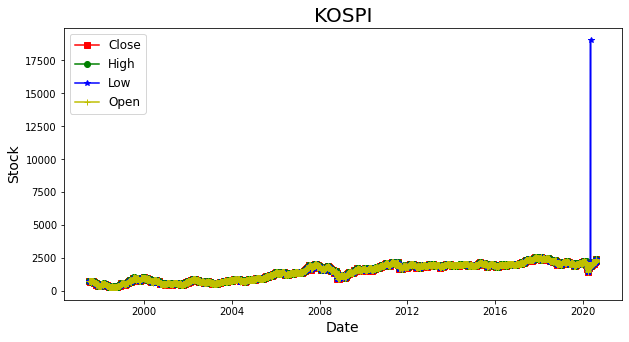

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
#Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI', fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

어라? 데이터가 뭔가 이상하다!

2020년 이후에 파란색 Low 가격에 이상한 값이 삐죽 솟아있는 부분이 눈에 뜁니다.

이렇게 비정상적으로 데이터 그래프가 솟아오른 부분을 스파이크(spike)라고 하고, 움푹 꺼진 부분을 딥(dip)이라고 합니다.

여러분, 당황 하지말고 침착히 상황을 분석해 봐요.

이상한 스파이크는 2020년 이후에 발생했고, Low Price 값이High 프라이스보다 훨씬 높게 삐죽 솟아 나와 있으니 확실히 이상한 데이터네요.

구체적인 수치를 확인하기 위해 pandas DataFrame에서 확인해 봅니다.

In [10]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume
5620,2020-05-06,1919.449951,1928.76001,19025.550781,1928.76001,1928.76001,1082200.0


범인은 2020년 5월 6일 이었네요. Low Price가 19025로 나타나 있어요.

이제 여러분은 시계열 데이터의 이상치 데이터가 무엇인지 감을 잡을수 있을 거에요.

이번에는 다행히 그래프를 통해 눈으로 여러분의 첫번째 이상치 데이터를 찾을 수 있었어요.

하지만, 이런 생각이 스쳐 갑니다.

###"이 이상치 데이터는 어떻게 처리하지?"

다음 단계에서는 이상치 데이터의 종류와 처리 방안을 알아봅니다.

#**4. Outlier/Novelties 구분하기**

우리가 갖고 있는 주식데이터에 관한 도메인 지식에 따르면, 

저가는 무조건 다른 가격들보다 낮은 가격이어야 해요. 

이런 규칙에 맞지 않았기 때문에 2020년 5월 6일의 이상한 데이터를 찾아 낼 수 있었어요.

이렇게 이상한 데이터, 즉 이상치(Anomalies)를 찾아내는 방법이 Anomaly Detection 입니다.

일반적으로는 이상치를 정상적인 데이터들의 분포에서 벗어난 데이터라고 정의하지만, 

세부방식에 따라 크게 Outlier와 Novelties 두 가지로 구분할 수 있습니다.

Outlier의 사전적 정의는 다음과 같습니다.

##통계적 자료 분석의 결과를 왜곡시키거나, 자료 분석의 적절성을 위협하는 변숫값 꼬는 사례.

Outlier는 일반적으로 단변량 분석의 결과로 찾아낼 수 있으며, 교정하지 않으면 자료 분석에 방해가 된다는 특징이 있습니다.

(대응 방안)특히, 비정상적인 데이터 수집 과정에 의한 극단치는 원본 데이터를 교정하여 없애는 걸 권장합니다.

- 참값으로 대체하거나
- 보간으로 대체하거나
- 삭제해야 합니다.


다행이 주식데이터는 네이버, 카카오 등 다양한 IT업체에서도 제공하는 데이터이다.

Supervised 방법을 통해서 데이터를 검증할 수 있어요.

카카오 주식차트로 확인해보면 Low는 1903이 맞는 값이네요.

반올림을 고려하면 야후에는 소수점 한 칸이 밀려서 입력된거 같습니다.

앞서서 발견된 이상치(2020년 5월 6일 Low값)은 비정상적인 수집 결과이므로 해당 데이터를 교정하여 없애봅시다.

In [11]:
#카카오 주식차트 결과로 대체합니다.
df.loc[df.Date == '2020-05-06', 'Low']= 1903

#비정상데이터가 제거되었는지 다시 확인해 봅니다.
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


**두 번째는, Novelties 특이치**

Novelties는 정상적인 수집과정에 의한 이상치를 의미합니다. 

이전까지는 보지 못한 패턴이나 데이터가 여기에 해당해요.

마치 블랙스완처럼요! 특이치는 우리가 모르는 도메인의 변화를 시사해요.

특이치는 일반적으로 다변량 분석의 결과로 탐색할 수 있어요.


**(대응방안)**

특이치는 극단치와 다르게 원본 데이터를 수정하지 안습니다.

나중에 특이치가 또 발생하면 모델이 대처해야 하거든요!

우리의 코스피 데이터에서는 코로나 사태로 인한 주식하락 같은 날벼락도 일종의 특이치 Novelties로 볼 수 있겠죠?

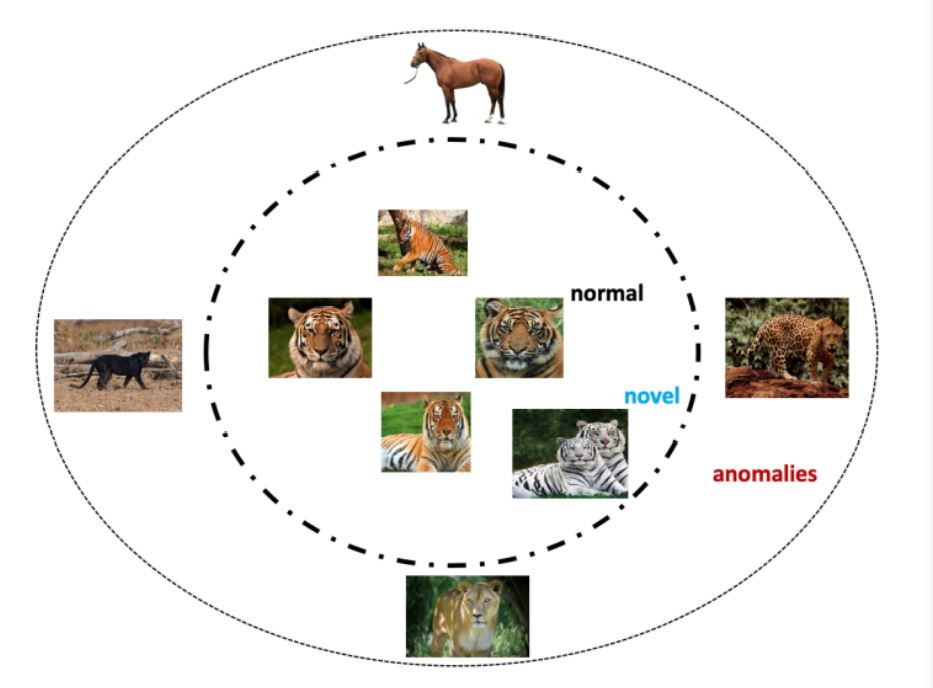

위 그림은 Novelty와 Anomalies의 개념적 차이를 설명하기 위해 제공된 것입니다.

정상적인 범주에서 벗어나는 이상 데이터라고 해도 엄밀히는 같은 것이 아니라는 것을 알 수 있을 겁니다.

위 그림을 예로 들자면, 만약 우리가 호랑이 라는 데이터를 조사한다고 했을때, 

하얀 호랑이 라는 것이 아무리 처음 관측되었다고 해도 그것이 호랑이의 범주에 든다면 그것은 특이치(Novelty)로 취급되어 호랑이 데이터 안에 포함되어야 합니다.

그러나 호랑이 데이터 안에 실수로 사자나 표범 같은 호랑이 범주 밖의 데이터가 끼어들었다면 그것은 극단치(Outlier)로 간주해서 호랑이 데이터에서 제외해야 하는거죠.

위 그림에서는 Normal의 범주 밖에 있는 것을 Outlier라고 하지 않고 Anomalies로 표기하고 있네요.

**Recap!!**

(세줄 요약)
- 이상치(Anomailies) = 극단치(Outlier) + 특이치(Novelites)
- 극단치는 제거해야 모형에 좋습니다.
- 특이치는 남겨둬야 모형에 좋습니다.

**모든 데이터에서 똑같은 방법으로 극단치와 특이치로 구분하나요?**

극단치와 특이치에는 사실 뉘앙스의 차이가 있을 뿐 명확한 구분 방법은 없습니다.

분석자의 주관이나 데이터의 도메인(분야)에 따라 조금씩 달라요.

결국 그 데이터 범주의 경계선을 어디에 그었느냐의 문제가 귀결될 것이기 때문에, 해당 도메인의 지식이 중요하게 취급됩니다.

우리가 다뤘던 주식 데이터에서도 만약 Open/Low/Close/High 등 데이터의 의미를 모르고 분석했다면 2020-05-06일 이상치를 찾아낼 수 있었을까요?


#**5. 전통적인 방법으로 이상데이터를 찾아보자!**

다른 출처에서 제공하는 데이터가 있다면 상호 비교하는 Supervised 방법으로 하나의 이상치를 제거할 수 있을 것입니다.

하지만, 야후 파이낸스와 달리 네이버/ 카카오는 코스피 데이터의 다운로드 기능을 제공하지 않습니다.

눈으로 하나하나 확인해볼 수도 없는 노릇! 

여러분은 숨어있을 다른 이상치들은 어떻게 처리하나 고민~고민하다가 예전 중고등학교 시절 배웠던 **정규분포**의 개념이 떠올랐어요.

어떤 데이터가 평균과 표준편차로 주어지는 정규분포를 따른다면 아주 높은 확률로 그 데이터는 어떤 **신뢰구간** 내에 있을거라고 가정할수 있으며.

그 신뢰구간 밖의 데이터가 나올 확률은 매우 희박해진다면 **신뢰구간 밖에 있는 데이터는 이상치** 라고 생각할 수 있지 않을까요?



In [12]:
pip install statsmodels


**기억 더듬어 보기: 신뢰구간**

중고등학교 시절 배웠던 '정규분포'와 '신뢰구간'의 개념을 잠깐 되짚어 볼까요?

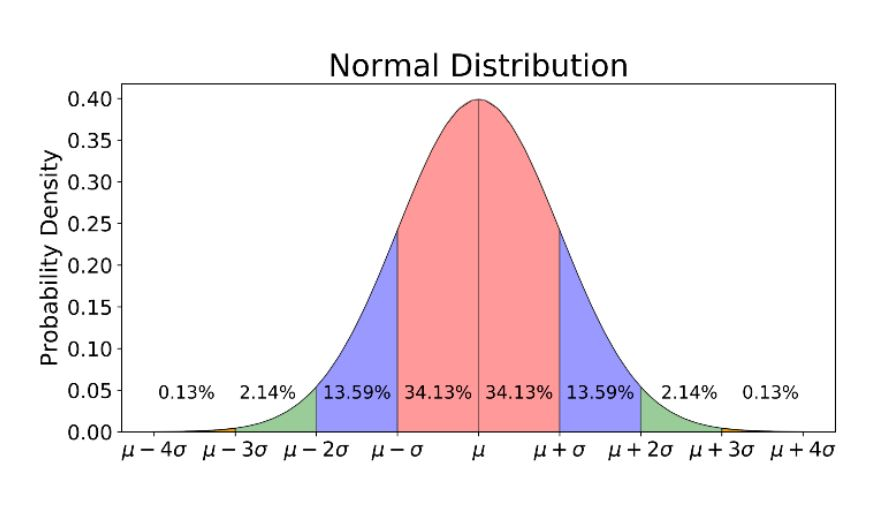

이번에 우리는 데이터가 '정규분포'를 따를때 사용 가능한 신뢰구간으로 이상치를 탐색할 거에요.

데이터가 정규분포를 따를 떄, 표준편차(o)의 배수로 신뢰구간의 상한과 하한을 결정해요. 

신뢰구간을 벗어나는 데이터는 일반적인 분포에서 벗어나는 '이상치'로 의심할 수 있어요.

- (2o를 기준으로 판단하면) 95.5%는 정상 데이터, 4.5%는 이상치
- (3o를 기준으로 판단하면) 99.7%는 정상데이터, 0.27%는 이상치로 분류할 수 있어요.

**(여기서 잠깐)

신뢰구간 분석을 통해 이상치를 찾아내는 방법은 데이터가 정규분포를 따를 때만 쓸 수 있는것은 아니랍니다.

데이터가 t-분포 등 특정 확률분포에 피팅이 된다면 그 확률분포의 신뢰구간 결정 방법을 적용할 수 있어요.

이상치를 찾아내는 통계적인 방법은 정말 다양하지만, 우리는 아래 두 가지 대표적인 방법을 알아보겠습니다.

- 정규분포르 따르는지 확인하는 방법:**z-test**
- 시계열 데이터중에서 정규분포에 가까운 데이터를 뽑아내는 방법: **Time series decomposition**

**z-test: 우리 데이터는 정규분포일까?** 

우리가 가진 코스피 데이터의 분포를 그래프로 확인해 볼게요.

정규 분포는 다음과 같이 그릴 수 있어요.

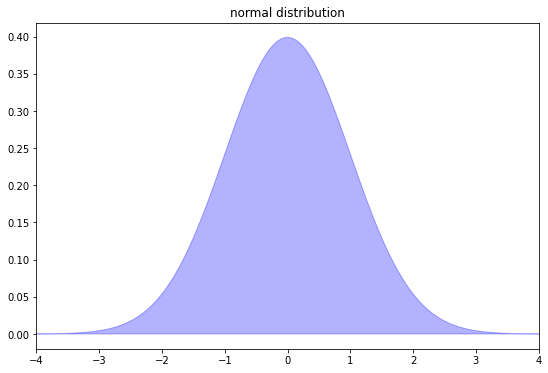

In [13]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.001)
y = norm.pdf(x, 0, 1)
#평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

#build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

우리 데이터도 이런 분포를 가진다면 참 좋을 거에요

그럼 우리 주식 데이터의 분포를 확인해 볼까요?

대표적으로 주식의 '종가 Close'를  그려볼게요


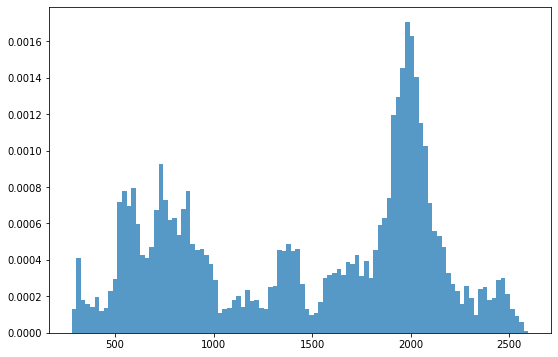

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

한눈에 봐도 딱 정규분포와는 거리가 먼 분포네요... 가운데가 전혀 볼록하지 않아요.

하지만 직관이 아닌 숫자로 판단해 봅시다!

단변수의 정규분포 여부는 z-test 방법으로 확인할 수 있어요.


1. 단일표본 z검정

z검정은 z분포를 가지고 모집단의 통계치와, 나(연구자)의 통계치를 비교하는 방법입니다. 

이를 비교하기 위해선 표준정규분포를 이용하여 가설을 검증합니다. 

단일표본 Z검정은 말 그대로 표본이 1개 있는 것으로 하나의 표본을 가지고 비교를 하는 방식입니다.

단일표본 Z검정의 기본 가정은

1) 종속 변수가 양적 변수

2) 정규분포 가정.

3)등분산 가정

4) 모집단의 분산을 알고 있을때 입니다.

여기서 4번이 중요한 것은 모집단의 분산을 알지 못하면 Z검정을 사용할 수 없습니다.

그때는 이후 다룰 T검정을 사용하게 됩니다.


단일표본 Z검정의 절차는 아래와 같습니다.
1. H0, H1을 세우고, a(알파), n(표본)을 설정
2. x bar(평균)을 계산
3. SE(표준오차) 계산
4. Z 통계치 계산
5. p-value와 a비교 or z값으로 비교
6. 통계적 기각여부 확인


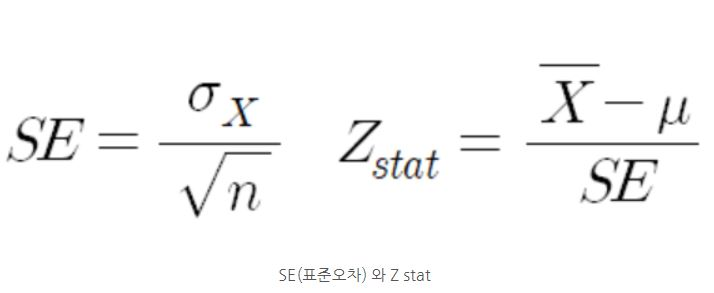



이를 문제에 대입해 보겠습니다.

    예제1)
    지난 오랜기간 동안 두두고등학교 학생들의 수학 점수를 알아보았는데, 평균 
    점수는 75점 표준편차는 15점인 정규분포를 따랐다.
    올해 2019년도에 두두고등학교 100명의 학생들을 대상으로 수학점수를 
    확인하였더니 평균점수가 79.5점이 나왔다. 2019년도에 실시한 수학점수와 이전 
    수학점수 간의 평균이 같은지 유의수준 a=0.05에서 검정하고자 한다.


여기서 Z검정의 4번째 특징인 모집단의 분산을 알아야한다는 점을 충족하고 있으므로 

Z검정을 사용합니다. 또한, 평균이 '같은지'를 검정하는 것이므로 양측검정을 

사용합니다. (등호 =, ≠ 사용). 유의수준은 0.05로 언급이 되었는데,

유의수준이 전혀 언급되지 않았을 경우에는 사회과학의 기본인 0.05를 사용하시면 됩니다. 앞서 말씀드린 공식 절차를 이용한다면.

1.귀무가설 H0: u=75, 대립가설 H1: u != 75

2.유의수준(a:알파) =0.05,


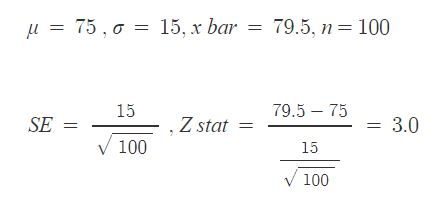

순서대로, SE(표준오차), Z stat에 대입을 하면 나(연구자)의 통계치가 3.0이 나오게 됩니다.

이제 모집단의 표준정규분포와 나의 Z값을 비교하면 되는데요, '같은지'를 검정하는 것이기 때문에 '양측검정'을 사용하여야 합니다.

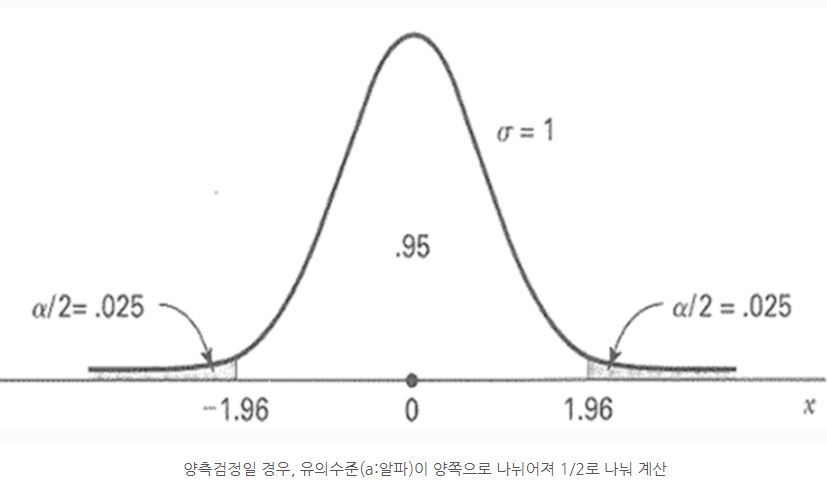

왼쪽 오른쪽 그래프의 양쪽을 검정하는 것이기 때문에 유의수준도 2로 나눠 계산해야 합니다. 그렇게 되면 유의수준 a=.025가 되고, 0.025의 Z값은 1.96이 됩니다.

하지만 우리의 Z값은 3.0이기 때문에 그래프 상 더 극단값 쪽으로 향하게 됩니다.

그렇게 되면 귀무가설을 기각하게 되므로 대립가설을 받아들이게 됩니다.

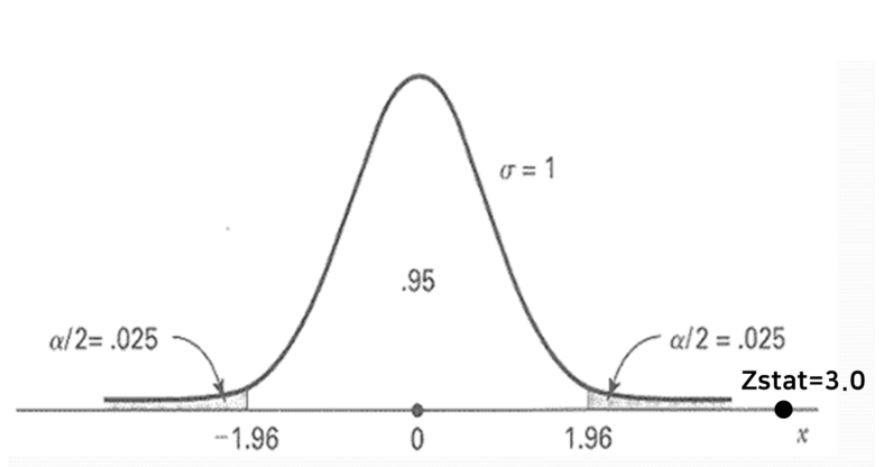


Z stat 값을 p-value로 변환하면, 0.00135가 됩니다.

p-value = .00135< a/2= .0025

Z stat = 3.0 > Z crit = 1.96

이므로, 귀무가설을 기각합니다.

*결론: 두두고등학교의 수학점수 평균은 통계적으로 이전의 수학점수 평균과 다르다.

라는 결론이 내려지게 됩니다.


여기서 Z stat 값을 p-calue로 변환하는 과정이 쉽지 않으므로(저 역시 R프로그램으로 변환) Z값끼리 비교하면 편합니다. 

**여기서 주의해야 할 점은, p=value는 값이 유의 수준보다 작아야 귀무가설을 기각 하는 것이고, Z값은 더 커야 귀무가설을 기각한다는 점입니다.**

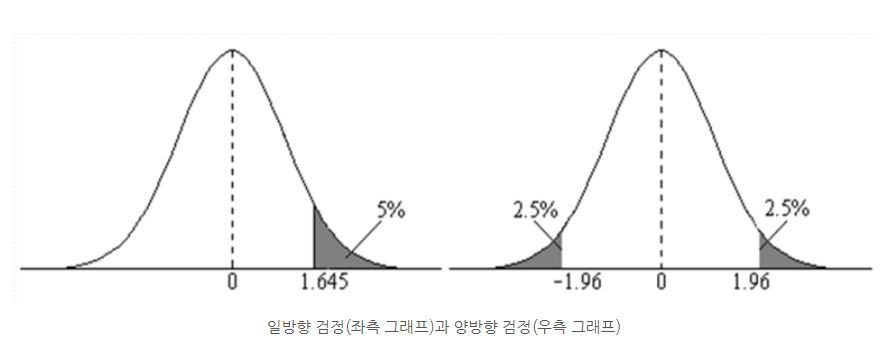



또한, 일방향 검정과 양방향 검정이 나뉘어 지게 되는데요. 일방향 검정은 말 그대로 한방향으로의 검정이기 대문에 그래프의 우측을 가지고 비교합니다.

반대로 양방향은 양쪽 좌우 모두를 검정해야 하기 때문에 유의 수준을 젋반으로 나눠서 계산합니다.

주로, 통계적으로 검정할 때 '같은지, 차이가 있는지'와 같은 문장이 들어가면 양방향 검정. '높은지, 낮은지'와 같은 문장이 들어가면 일방향 검정을 사용합니다.


**2. 두표본 Z검정**

방금은 단일 표본 Z검정이었다면, 이번에는 표본이 2개인 두표본 Z검정입니다.
계산 절차는 단일표본 Z검정과 동일하지만 SE와 stat값을 구하는 식은 다르니 이 점을 유의해주시면 되겠습니다.

    예제2) 
    연구자 '두두'가 전국 20대 남녀 100명을 무작위로 뽑아 몸무게를 측정하였는데, 
    남자의 평균 몸구게는 68kg, 여자는 50kg이었다. 또한, 20대 모집단 남자의 체중 
    표준편차는 10kg이고 여자는 9kg을 알고 있다.
    여기서 20대 남녀의 체중이 차이가 있는지 여부를 검정하여라.

여기서 모집단의 표준편차를 알고 있으므로 Z검정, 유의수준이 언급되지 않을 때는 0.05로 설정하므로 a=.05로 설정합니다.

또한 남자와 여자라는 두 표본이 있으므로 두 표본 Z검정을 사용합니다.

1. 귀무가설 H0: u1=u2(차이 없다), 대립가설 H1:u1 != u2(차이 있다.)
2. 유의수준(a:알파) = 0.05,

o1 = 10, o2=9, xbar1 = 68, xbar2 =50, n = 100

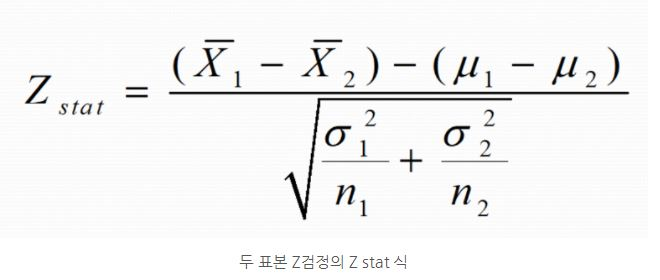


두 표본 Z검정의 식은 위와 같습니다. 차례로 대입을 하게 되면,

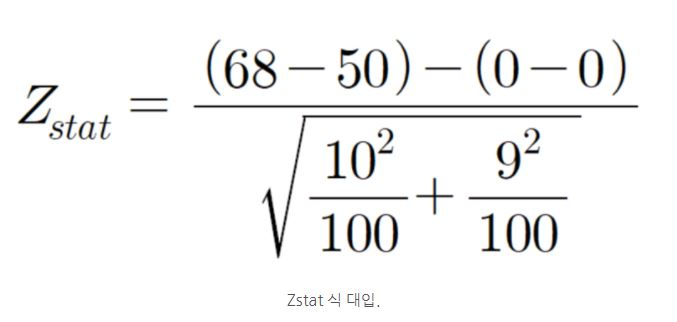



위와 같은 식이 나오게 됩니다. 최종적으로 계산을 하면, 

Zstat = 13.3792946324이 나오게 됩니다. 이때, 양방향 검정이므로 a=.025에서 검정을 하게 되면, 

Zstat 13.38 > Zcrit 1.96 이므로, 귀무가설을 기각하게 되고 결론적으로 20대 남녀의 몸무게 차이는 있는것으로 통계적으로 증명 가능하게 됩니다.

* 여기서 Z stat식에서 (u1-u2) 이게 왜(0-0)이 됐는지 궁굼하신 분들이 많을 겁니다. 

그 이유로는, 우리는 가정할때 귀무가설이 참임을 먼저 가정을 하고 시작한다고 하였습니다. 저희가 계산 절차에서 첫 번째로 귀무가설, 대립가설을 세웠는데요.

<1.귀무가설 H0: u1=u2(차이 없다), 대립가설 H1: u1 !=u2 (차이 있다)>

바로 여기서 귀무가설 u1=u2라고 가정했기 때문에 u1-u2는 0이 되는 것입니다.

**3. 단일표본비율 검정, 두 독립 표본 비율 검정**

단일표본 비율 검정과 두 독립 표본 비율 검정도 사실 다를게 없이 '비율'로 들어갔다는 점, 표본이 하나인지 두개인지에 따라 달라진다는 점입니다.

앞서 말씀드린바와 비슷하므로 공식 위주로 언급하겠습니다.


-단일 표본 비율 검정

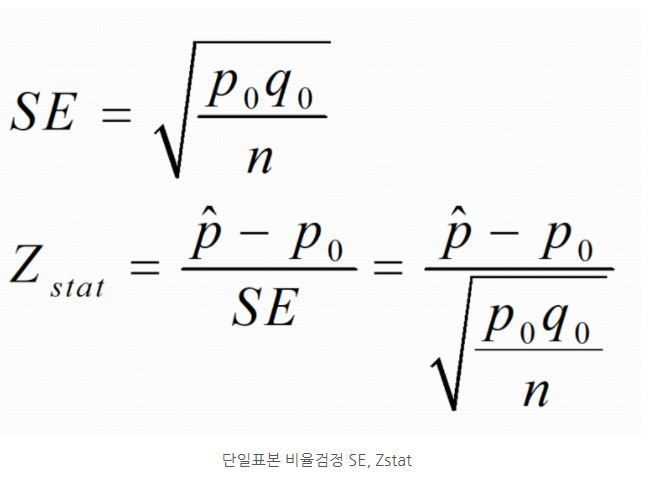

여기서 p0는 문제에서 언급되는 모집단의 비율이며, q0은 1-p0입니다. p hat은 우리가 알고 있는 비율입니다. 즉, 문제에서'모집단의 반대 비율이 0.6이었고, 이를 토대로 이번에 연구를 했을 때 , 반대비율은 0.5였다' 라고 했을때,

p0= 0.6, q0=(1-p0)이므로 1-0.6 = 0.4가 됩니다. 또한, p hat은 우리가 조사를 통해 알게 된 비율이므로 0.5가 됩니다.

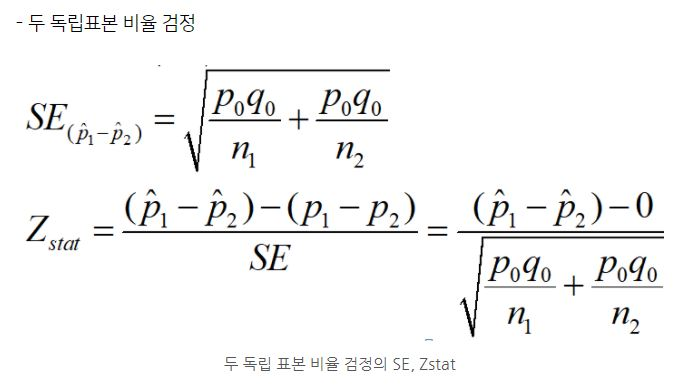

위의 식과 같습니다. 표본이 두 개이기 때문에 더 복잡할 수밖에 없는데요. 문제에 주어진 식을 잘 파악하고 대입하기만 한다면 문제없이 풀 수 있습니다. 

그러나, 모집단의 비율을 알 수 없는 문제가 주어지는 경우가 많습니다.

    예제3)
    연구자 '두두'가 서울시 '자전거 따릉이'에 착안을 받고 경기도에도 이 제도를 
    도입하려고 30대 여성 200명, 남성 250명 을 추출하여 찬성 여부를 물은 결과,
    여성은 140명 찬성으로 찬성비율 0.7, 남성은 75명 찬성으로 찬성비율 .3 이었다.
    유의수준 .05로 정하였을때, 두 비율간의 차이가 있는지 통계적으로 검정하시오
  

라고 주어졌다고 가정합시다. 이때, 문제를 보시면 모집단의 비율이 언급되지 않습니다.

그러면 저희는 SE를 구할수가 없게 되죠. 그럴 경우에 통합비율을 사용하게 됩니다.

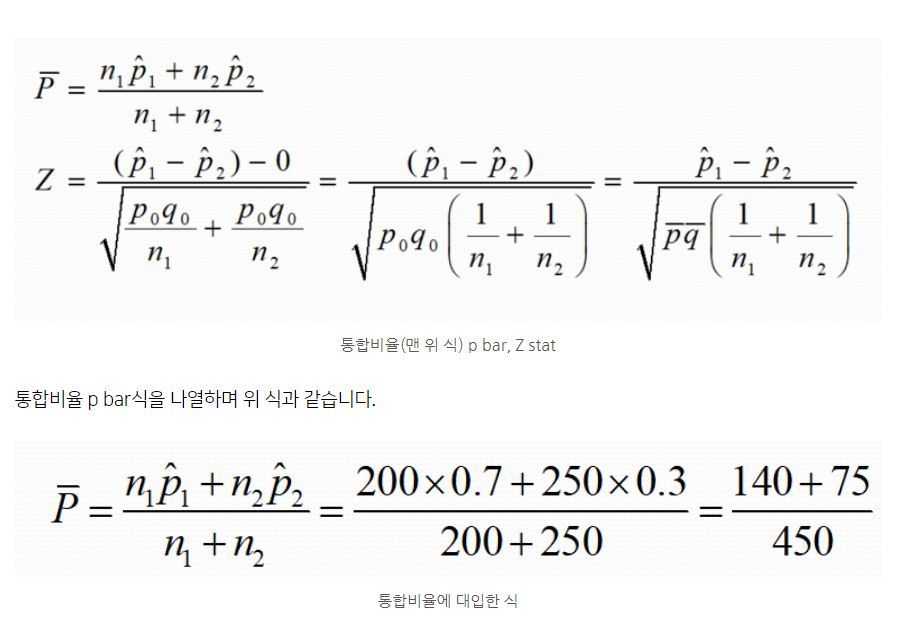



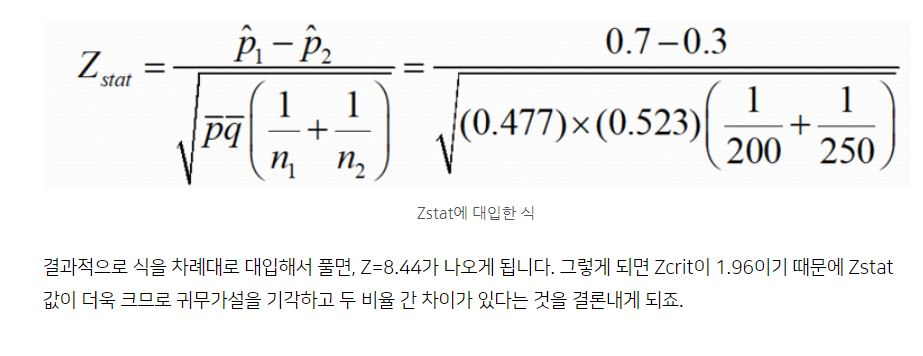

###2. T검정(T-test)

**1.단일표본 T검정**

다음은 T검정입니다 T검정은 표본의 크기가 작을 때(주로 20개 이하) 사용하며,

두 집단 간의 평균 차이를 검정하는 방법입니다. 이 단일 표본의 가정은 이렇습니다.

1) 종속변수가 양적변수 2) 종속변수 값이 정규분포라고 가정 3)등분산 가정(두 집단 T검정만) 4) 모집단의 분산을 모를 때

입니다. 

먼저 T분포는 표본의 크기가 작기 때문에 표본의 크기가 증가하면 증가할수록 정규분포를 따르게 되고 Z검정에 가까워진다는 가정이 있습니다.

단일표본 T검정의 검정 절차는 아래와 같습니다.
1. H0, H1을 세우고, a(알파), n(표본)을 설정
2. x bar(평균), Sx(표준편차) 계산
3. SE(표준오차)계산
4. t 통계치 계산
5. p-value 와 a비교 or t값으로 비교
6. 통계적 기각여부 확인

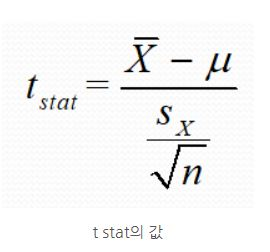

보시면 검정 절차는 Z절차와 거의 동일합니다. 그대신 문제에서 '모집단의 분산(표준편차)'가 주어지지 않는 다는 점 입니다.

하지만 표본의 표준편차는 식으로 주어지기 때문에 이를 대입하시면 됩니다.

**2. 두표본 T검정**

두 표본 T검정은 말 그대로 표본이 2개인 경우인데요, 이 역시 두 표본의 n수, 표준편차, 평균이 주어지기 때문에 식에 대입만 하시면 됩니다.

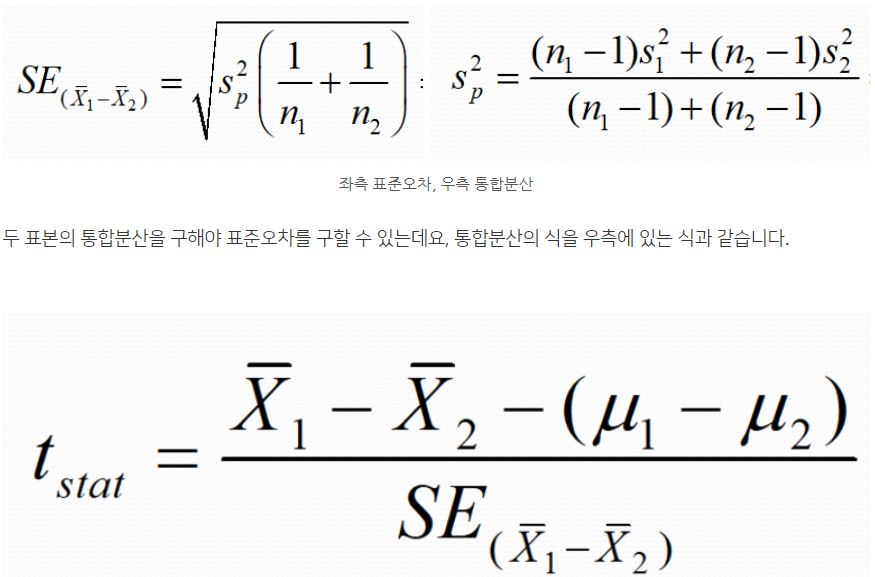

최종적으로 tstat에 대입하여 풀면 통계적으로 accept 하는지 reject하는지 알아낼 수 있습니다.

두 표본 t검정에서 자유도는(n1-1)+(n2-1)로 전체사례수 -2 입니다.

자유도에 따라 tcrit이 바뀌게 되므로 주의하셔야 합니다.

특히Z검정과 T검정의 또다른 차이는 z table t table이 다르다는 것인데요, Z값에서 1.96 은 a=.025였습니다.

하지만 t table에서의 a=.025는 t stat = 2.262로 다르므로 표를 보실때 자유도와 함께 고려하여 확인하여야 합니다.

**3. 종속표본 t검정**

마지막으로 종속표본 t검정 인데요. 집단 간 서로 종속이 되어 있어서 종속표본 t검정이라고 합니다.

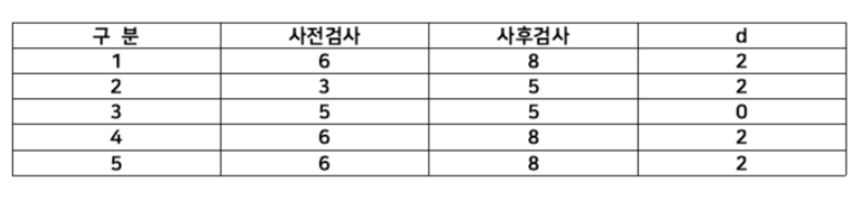

위 식처럼, 사후검사는 사전검사에 종속이 되어 있기 때문에 이러한 전, 후 효과비교에 대한 검정은 종속표본 t검정을 사용하시면 됩니다. 우선(사전검사-사후검사)를 통해 d 값을 알아내시고, d 값의 평균을 구합니다.(평균=.16)

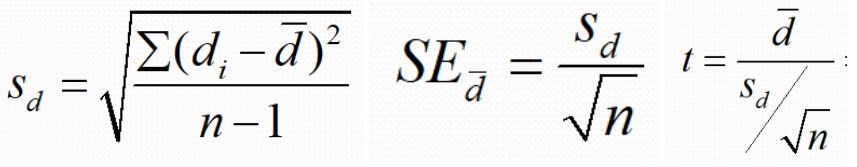

그리고 차례대로 식을 대입하면 t=4로 나오게 됩니다. 종속표본 t검정에서의 자유도는 (n-1)입니다!

t-test는 주로 사회과학 분야에서 많이 쓰이는 통계입니다. 그 이유로는, 우선 모집단의 분산을 알 수 ㅇ벗는 경우가 대다수 이기 때문에 t-test를 많이 이용하고 있죠.

In [16]:
from statsmodels.stats.weightstats import ztest
_, p= ztest(df.Close)
print(p)

0.0


- p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다는 뜻이에요.
- 즉, 이런 데이터로는 '정규분포'를 가정한 통계적 추정이 어려워요
- 그렇다면 이 데이터에 대해서는 정규분포를 가정한 신뢰구간 분석은 적용하기 어려울 것입니다.

###**시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법: Time series decomposition**

**시계열 데이터의 3가지 성분**

혹시 Stationary (정상성 또는 안정성)과 Time series decomposition(시계열 분해)에 대해서 배운 적이 있으신가요?

시계열 데이터의 예측 모델을 논할 때 Stataionary 개념은 절대 빠질 수 없습니다.

시계열 예측을 다룬다면 명확히 알아야 하는 개념이지만, 지금으로선 평균, 분산, 공분산이 일정한 Stationary 시계열에 대해서만 미래 예측이 가능하다는 기본 개념을 알아 둡시다.

하지만 우리가 다룰 대부분의 시계열 데이터는 Stationary 하지 않고 계속 변화하는 패턴을 보입니다.

이때, 시계열을 Stationary한 컴포넌트와 Non-stationary 한 컴포넌트로 나누어 분석하기 위해 주로 사용하는 기법이 Time series decomposition 입니다.

Time series decomposition을 통해 시계열 데이터는 3가지 성분으로 분리되고, 그중 

**Residual 성분의 데이터가 Stationary에 가까운 형태**를 가져요.

이때 **Stationary에 가까운 데이터는 정규분포를 따르지요!** 우리는 이 Residual 데이터를 사용해서 신뢰구간을 구할 수 있어요.




    Q4. statsmodel 에서 제공하는 Time series decomposition은 시계열 데이터를 
    3가지 패턴으로 분류해요. 그 세가지의 이름을 영어로 적어주세요!
    


    trend, seasonal, residual (또는 resid)

    Q5. Time series decomposition된 패턴 중에서 어떤 것이 stationary에 가까울 까요?

    residual (또는resid)

Time series decomposition은 'additive' 방법과 'multiplicative' 방법이 있어요.

본 예제에서는 additive 방법을 적용해 볼게요

Statsmodel 라이브러리를 이용해서 코스피 종가 데이터를 분석해 봅시다.

계절적 성분의 주기는 임의로 50일로 가정하겠습니다.

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [41]:
result = seasonal_decompose(df.Close, model='additive', two_sided=True,
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()


TypeError: ignored

In [35]:
fig. axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=Fasle)
axes[3].set_ylabel('Residual')
plt.show()  

In [36]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
#-8 에서 10 사이를 주기적으로 반복하는게 보이네요.

알수없는 이유로 오류가 발생한다 period 라는 파라미터가 없다고 해서 지워주면 extrapolate_trend 도 없는 파라미터 라고 나오고, 그거 마저 지워주면 알수 없는 오류가 발생한다.



##우리는 Time series decompose 결과에서 무엇을 알 수 있나요?
- 우리는 정규분포에서 표준편차를 이용한 이상치 인식을 사용하고 싶었어요
- 추세Trend와 계절적 성분 Seasonal을 뽑아내고 남은 잔차 Residual을 볼까요?
- 잔차는 평균 0을 기준으로 분포하고 있어요!
- 잔차가 큰 날은 뭔가 일반적인 추세나 계절성에서 벗어난 날로 해석되겠죠?
- 그럼 Residual의 분포를 그려보도록 하겠습니다.


In [38]:
fig, ax = plt.subplots(figsize=(9,6))
_= plt.hist(result.resid, 100, density=True, alpha=0.75)

위에서 result를 정의하지 못해서 코드를 돌릴수 없다..

이런 모양새면 정규분포로 가정해도 될거같죠? 

다시한번 z-test를 통해 숫자로 확인해 봐요.

In [40]:
r = result.resid.values
st, p = ztest(r)
print(st, p)

#마찬가지로 result를 정의하지 못해서 코드를 돌릴시 오류가난다.

p-value가 0.05이상으로 아주 강하게 나타나네요. 

데이터 분포가 정규분포를 잘 따르고 있다는 뜻입니다.

이러면 정규분포로 가정하고 분석해도 되겠어요!


    Q6. time series decompose 에서 two_sided=True의 의미는 무엇인가요?

    Trend 성분을 만들기 위해 freq 길이에 해당하는 샘플이 필요합니다. 이걸 
    rolling window로 만들어 냅니다.
    우리의 에제에서는 period=50 이기 때문에, 
    two_sided=True라면 049번째 데이터로 25번째 Trend값을, 150번째 데이터로 
    26번째 Trend 값을 생성합니다.
    
    two_sided=False라면 049번째 데이터로 50번째 Trend값을, 150번째 데이터로 
    51번째 Trend 값을 생성합니다.

    Q.7 time series decompose 에서 extrapolate_trend = 'freq'의 의미는 
    무엇인가요? 빼면 무슨일이 생기죠?

    위의 Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend,resid에는 Nan 값이 발생합니다.
    우리의 예제에서는 period=50이기 때문에 two_sided=True라면 맨앞에서 25개, 맨뒤에서 25개가 Nan이고,
    two_sided=False라면 맨앞에서 50개가 Nan입니다.
    이렇게 발생하는 Nan 값을 채워주는 옵션이 extraplate_trend입니다. 
    이옵션을 빼면 Trend와 Resid에 Nan값들이 생깁니다.




    Q8. Time series decompose 에서 additive 는 Observed[t] = trend[t] +seasonal[t] + resid[t] 였지요.
    만약, multiplicative 로 분석하면 어떤 결과가 나오나요?
    

    Obseved[t] = trend[t] x seasonal[t] x resid[t]
    위 식의 양변에 로그를 취하면 결과적으로 additive와 동일한 결과각 얻어진다.

#3σ 기준 신뢰구간으로 이상치 찾기

여러분은 신뢰구간 방법으로 이상치를 탐색하려고 해요.

평균을 기준으로 플러스. 마이너스 3σ 를 벗어나는 데이터를 찾아봅시다.

In [ ]:
#평균과 표준편차 출력
mu, std =result.resid.mean(), result.resid.std()
print("평균: ", mu, "표준편차:", std)

#3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수: ", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu*std)]))

5692개 데이터 샘플 중에서 71개의 이사이를 찾아냈습니다. 어떤 날들인지 확인해볼까요?

#신뢰구간 방법의 한계점은 뭘까?

2008년 금융위기 때와 2020년 코로나 위기가 있던 시기가 많이 잡혔네요!! 경제 위기가 닥치면 장기적인 패턴에서 벗어나게 되니, 일반적인 경제 상식에 비춰봤을 때 합리적인 결과로 생각 돼요.

아마 신뢰구간으로 걸러진 71개 이상치 후보군은 대부분 특이치(Novelty)라는 생각이 드네요.

그래도 Supervised로 5682개를 하나하나 확인하기는 어려웠는데, 71개로 줄엇으니 이제는 비교해도 좋을거 같아요.

하지만 여러분은 왠지 더 똑똑한 방법이 있을거 같아요.

사실 신뢰구간 방법에서는 종가 Close 하나의 지표만 활용해서 이상치를 찾아냈거든요.

다른 지표별로 분석해보면 71개가 아니라 몇백 개를 찾아봐야 할 수도 있어요.

**다양한 데이터로 더 그럴싸한 Anomalies 를 찾아낸 다음, 노가다를 최소한으로 하는** 그 방법을 **Multi-variable Anomaly Detection**이라고 불러요. 일반적으로는 두가지 알고리즘을 사용해요.

- Clustering: 클러스터링으로 묶으면 정상인 데이터끼리 이상한 애들끼리 그룹핑되니 이상한 그룹을 찾는다.

- Forecasting: 시계열 예측 모델을 만들어서, 예측 오차가 크게 발생하는 지점은 이상한 상황이다. 일반적으로 Auto-Encoder로 탐색한다.

다음 단계에서는 클러스터링으로 다변량 이상치 탐색을 하는 방법을 다뤄볼 거에요.

#**6. 클러스터링으로 이상치 찾기: K-means와 DBSCAN**

**데이터 전처리**

이번에는 Open, High, Low, Close, Volume 5가지 데이터를 모두 사용할 거에요.

앞서 살펴본 통계방식과 동일하게 Trend/Seasonal 성분을 제거해야 '정말 튀는' 데이터를 찾아낼수 있어요.

같은 방법으로 **5가지 데이터 모두** time series decompose로 전처리를 해줄 게요


In [42]:
#데이터 전처리
def my_decompose(df, feature, freq=50):
  trend = pd.DataFrame()
  seasonal = pd.DataFrame()
  resid = pd.DataFrame()

  #사용할 feature 마다 decompose를 수행합니다.
  for f in features:
    result = seasonal_decompose(df[f],
                                model='additive', period=freq, extrapolate_trend=freq)
    trend[f] = result.trend.values
    seasonal[f] = result.seasonal.values
    resid[f] = result.resid.values

  return trend, seasonal, resid

#각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open', 'High','Low','Close','Volume'])
tdf.describe()

TypeError: ignored

In [ ]:
rdf.describe()

각 변수마다의 잔차(residual)을 살펴보면 Volume 혼자서 너무 숫자가 크다는 걸 알 수 있어요.

이런 데이터를 그대로 분석에 사용하면 Volume이 가장 중요하게 반영될 거에요.

한쪽에 쏠리는 걸 제외하기 위해 각 변수들을 표준정규화 해줍니다.

In [43]:
#표준정규화 
from sklearn.prepocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

ModuleNotFoundError: ignored

**k-means 로 이상치 탐색하기**

우리는 k-means을 이용해서 정상 데이터그룹과 이상치 데이터그룹을 나눠볼 거에요.

이때, 그룹은 2개로 지정하면 되겠죠? 한번 코드로 확인해 보겠습니다.


In [44]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) #분류된 라벨은 이렇게 kmeans.labels_로 확인합니다.

NameError: ignored

In [ ]:
#라벨은 몇번 그룹인지 뜻합니다.
#return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_, return_counts=True)
print(lbl) #0번그룹, 1번그룹으로 나뉘어 졌네요.
print(cnt)

분석 결과 0번 그룹은 3283개의 샘플, 1번그룹은 2409개의 샘플로 분류 됐어요.(아마 여러분들의 수행 시점에는 숫자가 좀 더 커질 거에요.)

어느 한쪽을 이상치 그룹이라고 선택하기에는 너무 많이 분류됐네요.

그룹 숫자를 더 늘려서 분석해보겠습니다.

    Q9. k-means의 'random_state=0'의 뜻은 무엇일까요?
    

    k-means 는 난수를 이용하기 때문에 실행할 때마다 결과가 다를수 있어요.
    그래서 동일한 분석결과를 얻기 위해서는 난수설정값을 통일시켜주는 과정이 필요합니다.
    np.random.seed()와 비슷한 역할을 하는 코드에요.

from sklearn.cluster import KMeans

kmeans = KMeans(n_cluster=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_, return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

여러분들은 분류 결과가 어떻게 나왔나요? 저의 경우 3, 9, 10번 그룹의 경우 그룹 내 count가 10개이내로 분류된 매우 특이한 그룹으로 분류되었습니다.


다음 활동을 통해 이상치를 분석해 보겠습니다.

1. 어떤 날들이 분류된 건지
2. 각 그룹은 어떤 특징을 갖고 있는지
3. 왜 이상치로 분류된 걸까?

##**1. 어떤날들이 분류된 건지( 원본 코스피 데이터에서 탐색)**


In [ ]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요
df[(kmeans.labels_==3)|(kmeans.labels_==9)|(kmeans.labels_==10)]

In [ ]:
df.describe()

In [ ]:
#2004-04-14 주변 정황
df.iloc[1660:1670]


2. 각 그룹은 어떤 특징을 갖고 있는지

In [ ]:
#각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해 보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High', 'Low', 'Close', 'Volume'])

- 다른 그룹들은 거래량 값이 매우 작지만, 2개 그룹의 거래량 수치가 유독 큽니다. 저의 경우 3, 10번 그룹이 이 경우입니다.

- 그리고 Open, High, Low, Close 의 값이 유독 낮은 그룹이 하나 있습니다. 저의 경우 9번 그룹이 이 경우입니다.


##3.왜 이상치로 분류된 걸까?
- 3번 10번 그룹의 거래량은 비정상적입니다.

df.describe()로 알아본 전체 평균 거래량은 4,329,776 이에요

그런데 3번 10번 그룹은 거래량이 250,000,000 이상으로 평균 대비 60배 이상 많아요.

한번 인터넷 검색으로 이 값들이 맞는지 확해볼까요??

확인 결과 우린 다시 한번 야후 파이낸스의 실수를 찾아냈어요.

3번 10번 그룹의 거래량은 나누기 1000을 해야 정상적인 값이 됩니다.

- 9번 그룹은 각 그룹의 특징에서 답을 찾을 수 있었어요.

슬프게도 코스피 역사상 가장 큰 폭락장이었던 날입니다.


In [ ]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.Close.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.Close.plot(ax=ax, label='Resid', legend=True, color='y')
plt.show()

파란색은 실제 코스피 지수고, 빨간색은 트렌드, 그리고 잔차가 노란색입니다.

COVID19 때문에 2020년 3월에 발생한 폭락장으로 인해 아래로 깊게 파인 잔차가 보입니다.

기대했던 추세보다 너무 많이 하락한 거죠 즉, 우리가 예상하지 못한 이상치가 맞습니다.


**Recap**
우리는 Unsupervised Learning 중에서 k-means 알고리즘을 이용해서 Anomaly Detection을 해봤어요

1. 소수 그룹이 형성될 만큼 충분한 그룹수로 클러스터링한다.

2. 소수 그룹의 특징을 분석한다.

3. 해당 소수 그룹들이 이상치인지 추론해 본다

**DBSCAN 으로 이상치 찾기**

이번에 우리는 DBSCAN 을 이용해서 데이터를 클러스터링하고, 이상치 그룹을 찾아낼 거에요.

K-means와 달리, DBSCAN 알고리즘은 핵심벡터와 일정 거리 이내인 데이터 벡터들이 군집(Cluster)을 이루게 하는데,

그러한 군집들과 거리상 동떨어져 군집에 들지 못하는 특이한 데이터들을 노이즈(Noise) 벡터라 부릅니다.

DBSCAN을 통해 이상치를 찾는 것은 바로 이러한 노이즈 벡터를 찾는 것과 같습니다.


In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(ep=0.7, min_samples=2).fit(norm_rdf)
clustering

In [ ]:
#분류된 라벨들을 이렇게 확인할 수 있어요.
print(clustering.labels_)

In [ ]:
lbl, cnt = np.uniqe(clustering.labels_,return_counts=True)
['group{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

DBSCAN은 41개, 3개, 2개의 소수 그룹을 분류해 냈네요.

#**7. Auto-Encoder를 이용한 이상치 탐색**

드디어 여기까지 왔습니다.

앞서 살펴본 예제들의 기본 로직은 동일합니다.

1. Time series decomposition 을 이용해 Trend/Seasonal/Residual 값으로 분리한다.

2. Residual 값의 분포를 이용해서 이상치를 탐지해낸다.

##**통계적 방법과 Unsupervised Clustering 기법의 장점**
1. 적은 샘플 수로도 분석이 가능하다(샘플 수가 50개 이상이면 적용 가능)

2. 하드웨어 제약이 거의 없다.

##**통계적 방법과 Unspervised Clustering 기법의 단점
1. Time series decomposition에 의존해야 한다는 점

2. 분석자의 주관이 필요하다는 단점이 있었습니다.
( 통계기법: 몇 배수의 표준편차?, k-means:몇 개 그룹으로 클러스터링?, Time Series decompose: freq는 몇으로?)

우리는 대 딥러닝의 시대를 살고 있으니 이상치 탐색에도 딥러닝 모델을 적용해봐요.

딥러닝을 적용하면 다음 부분에서 장단점이 있습니다.

##**딥러닝 이상치 탐색의 장점**

1. Time series decomposition 없이 분석 수행이 가능하다.

2. Trend, Seasonal 데이터를 포함하고 있기 때문에 Trend, Seasonal의 변화도 이상치로써 탐색이 가능하다.

##**딥러닝 이상치 탐색의 단점**

1. 분석자의 주관이 어느 정도 필요하긴 하다(Threshold, window)

2. 학습에 활용할 만큼 충분한 데이터가 확보되어야 한다.

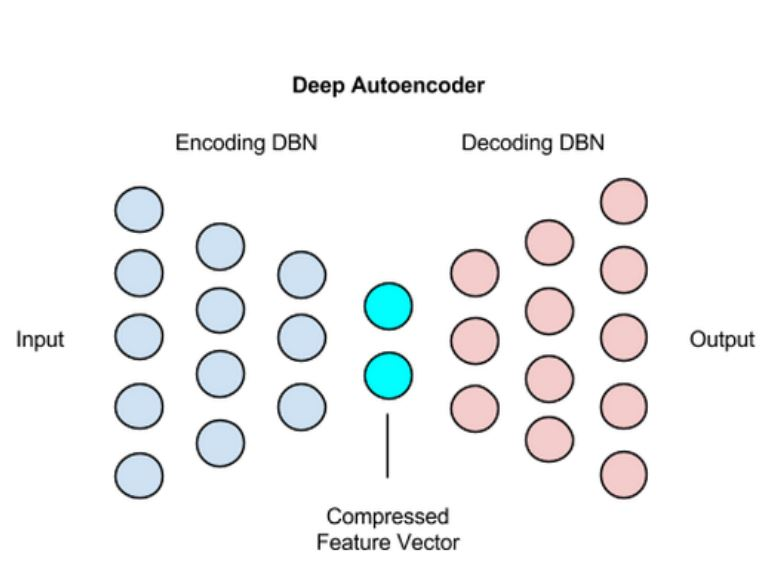


**Auto encoder란?**

- 오토인코더는 인코더와 디코더로 구성 됩니다.
- 인코더는 입력 데이터로부터 중요한 정보(Compressed Feature Vector)를 뽑아냅니다.
- 이 과정에서 입력데이터보다 압축된 형태의 데이터를 얻습니다.
- 디코더는 중요한 정보로 입력데이터와 유사한 형태를 재생성(Generate)합니다.

인코더가 중요한 정보를 '잘'뽑아내면, 디코더는 입력 데이터를 거의 똑같이 생성해낼 수 있겠죠?

비정상적인 데이터들은 디코더가 똑같이 생성하기 어려울 거에요.

우리가 오토인코더를 Anomaly Detection에 사용하는 이유입니다.

In [ ]:
#필요한 라이브러리를 불러옵니다.

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#모델 재현성을 위해 난수 시드 설정을 해줍니다.
tf.random.set_seed(777)
np.random.seed(777)

##**LSTM을 이용한 오토인코더 모델 만들기**
**데이터 전처리**
- 입력 변수를 정규화 시켜줘야 딥러닝 모델 학습이 원활합니다.
- 가장 일반적인 표준정규분포로 전처리해요.



In [ ]:
from sklearn.preprocessing import StandardScaler

#데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open', 'High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

#데이터 전처리
#표준정규분포화 합니다.

scaler = standardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE, features].values)
scaled = scaler.transform(df[features].values)

##**Keras TimeseriesGenerator 를 이용해서 간편하게 데이터셋을 만듭니다**

- data: 입력데이터 (x)를 넣어줍니다. 우리는 'Open, 'High', 'Low', 'Close', 'Volume' 5가지 인풋을 사용합니다.
- targets: 출력 데이터를 넣어줍니다. 우리는 5가지 인풋 그대로 예측하기 때문에 data와 동일한걸 넣어줍니다.

- length: 몇 개의 time_step을 참고할지 입력합니다.

- stride: time_step 사이즈를 결정합니다.
 

In [ ]:
#keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다.

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled
    length = window_size,
    stride = 1,
    sampling_rate = 1,
    batch_size = batch_size,
    shuffle = False,
    start_index = 0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride = 1,
    sampling_rate = 1,
    batch_size = batch_size,
    shuffle=False,
    start_index = TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

**모델 만들기**

- 2개 층의 LSTM으로 인코더를 만듭니다.
- RepeatVector는 input을 window_size만큼 복사해 줍니다.


In [ ]:
model = sequential([
  #>>인코더 시작
  LSTM(64, activation='relu', return_sequences=True,
       input shape=(window_size, n_features)),
  LSTM(16, activation='relu', return_squences=False),
  ## << 인코더 끝
  ## >> Bottleneck
  RepeatVector(window_size),
  ## << Bottleneck
  ## >> 디코더 시작
  LSTM(16, activation='relu', return_sequences=True),
  LSTM(64, activation='relu', return_sequences=False),
  Dense(n_features)
  ## << 디코더 끝
])

model.summary()

In [ ]:
#체크포인트
#학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

#얼리스탑
#학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다.

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam', metrics=["mae"])

In [ ]:
hist = model.fit(train_gen,
                 validation_data=valid_gen,
                 steps_per_epoch=len(train_gen),
                 validation_steps=len(valid_gen),
                 epochs=50,
                 callbacks=[checkpoint, early_stop])

In [ ]:
model.load_weights(checkpoint_path)

**학습 과정을 확인해 보겠습니다.**
- 안정적으로 Training loss가 수렴하고
- Validation loss가 발산하지 않음을 확인


In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

##**분석 시 주의할 점!!**

우리는 시계열 데이터를 window_size 만큼 밀어가면서 예측하는 모델을 만들었어요.

그래서 train_gen 의 길이는 원본 df의 길이보다 window_size 만큼 짧습니다.

예측 결과와 비교할 대는 scaled의 앞에서 window_size 만큼 건너뛰어야 해요.

In [ ]:
#예측 결과를 pred 로, 실적 데이터를 real로 받습니다.
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

#샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다.
fig,ax = plt.subplots(figsize=(9,6))
_=plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

**어라? mae_loss가 3 이상으로 동떨어진 샘플이 몇 개 보이네요?**

아무래도 우리가 찾는 이상치 같습니다. 좀더 자세히 확인해 보겠습니다.

mae_loss의 기준치를 3으로 해서 분석합니다.

scaled 데이터는 스케일링 조정되어있기 때문에 원본 데이터인 df로 비교해야 합니다.

기존의 df와 mae_loss까지 합쳐서 분석하기 위한 데이터프레임을 새로 하나 만들어요.

In [ ]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss']=mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

우리가 Clustering 에서 찾았던 Volume 이상치를 4개를 똑같이 찾았네요!

이상치 탐지가 정상적으로 동작하는 거 같아요!!

기준치를 더 낮춰서 보다 많은 이상치를 찾아보겠습니다.

In [ ]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

**그래프로 그려서 이상치를 찾아봐요**
- Open, Close, Low, High 같은 데이터는 스케일이 비슷하니 한 번에 그려도 좋을 거에요.

- 하지만 Volume과 loss는 스케일이 다르니 각각 그래프를 그려봐요

- 기준치로 분류해낸 이상치들은 붉은 점으로 그려서 나타내요


In [ ]:
fig = plt.figure(figsize=(12,15))

#가격들 그래프입니다.
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss > threshold])

#거래량 그래프입니다.
ax = fig.add_subplot(312)
ax.set_title('volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

#오차율 그래프 입니다.
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

그래프에 붉게 표시된 이상치들이 한눈에 보이시나요?

이렇게 코스피 데이터에 있는 이상치들을 찾아 봤습니다.
    
